# 取得Mask

In [1]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import concurrent.futures
from draw import draw_bounding_box_on_image as draw
from PIL import Image

In [2]:
# Initialize the COCO api for instance annotations

coco_path = r"C:\Users\sky66\fiftyone\coco-2017\raw\\"

val=COCO(coco_path+"instances_val2017.json")
train=COCO(coco_path+"instances_train2017.json")

# Load the categories in a variable
# catIDs = coco.getCatIds()
# cats = coco.loadCats(catIDs)

val_catIds = val.getCatIds(catNms=["person"]) 
val_imgIds = val.getImgIds(catIds=val_catIds)

train_catIds = train.getCatIds(catNms=["person"]) 
train_imgIds = train.getImgIds(catIds=train_catIds)

# img = coco.loadImgs(imgIds[0])[0]

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=16.17s)
creating index...
index created!


In [29]:
def mask(coco, anns):
    mask = coco.annToMask(anns)  
    return mask    

In [30]:
def mask_v1(imgIds, catIds, coco, name):
    for img in imgIds:
        img = coco.loadImgs(img)[0]
        if img['file_name']==name:
            break    
            
    # print(img)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)  
    mask = coco.annToMask(anns[0])  
    return mask

In [25]:
def data(imgIds, catIds, coco, name):
    for img in imgIds:
        img = coco.loadImgs(img)[0]
        if img['file_name']==name:
            break  
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)        
    anns = coco.loadAnns(annIds)          
    return anns[0]

In [26]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\train\data"+"\\"
imgs = list(os.listdir(imgPath))

In [27]:
# https://www.cnblogs.com/ywheunji/p/12052770.html

133 292 332 448


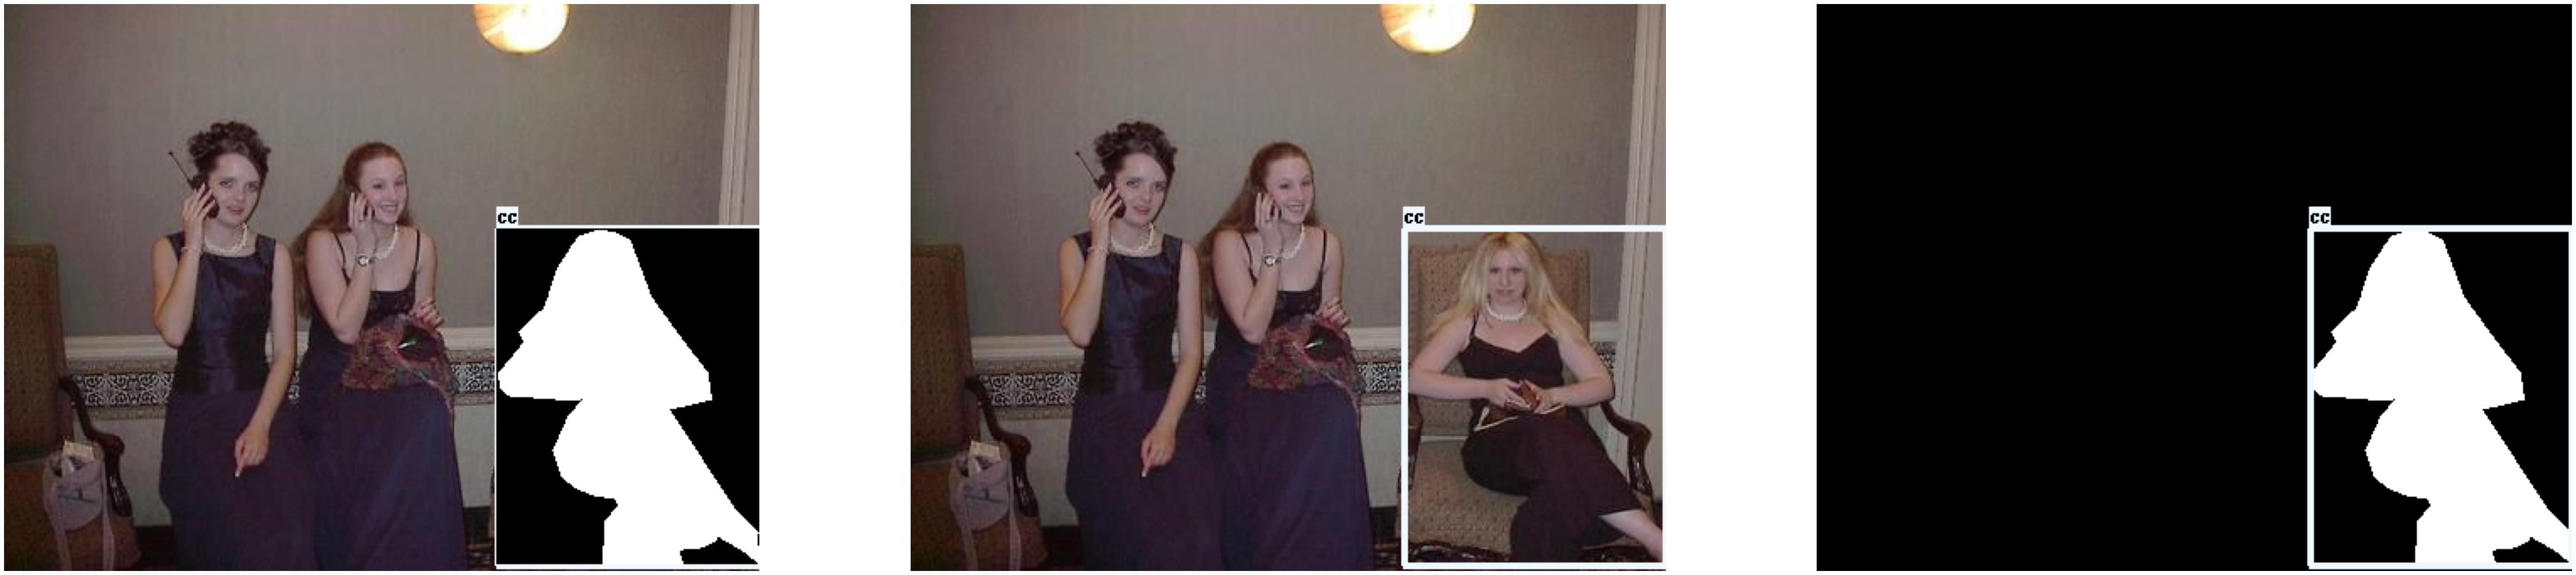

In [31]:
def vw(ids, isMask=True, isTrain=True, imgPath=None):
    if isTrain:
        b = mask_v1(train_imgIds, train_catIds, train, imgs[ids])
        d = data(train_imgIds, train_catIds, train, imgs[ids])["bbox"]
    else:
        b = mask_v1(val_imgIds, val_catIds, val, imgs[ids])
        d = data(val_imgIds, val_catIds, val, imgs[ids])["bbox"]
        
    if isMask:
        b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)*255
    else:
        b = cv2.imread(os.path.join(imgPath,imgs[ids]))
        b = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
    s = b.shape
    x, y, w, h = d
    x0, y0, x1, y1 = [int(r) for r in [y, x, y+h, x+w]]
    print(x0, y0, x1, y1)
    bp = b[x0:x1, y0:y1]
    ymin, xmin, ymax, xmax = y/s[0], x/s[1], (y+h)/s[0], (x+w)/s[1]
    b = draw(b, ymin, xmin, ymax, xmax, display_str_list=["CC"])
    b = np.array(b, dtype="uint8")
    # b = Image.fromarray(np.uint8( np.array(b) ) )
    return b, bp
def vi(imgs):
    fig, ax = plt.subplots(1, len(imgs), figsize=(80,80))
    for i in range(0,len(imgs)):                       
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
    plt.show()     

ids = 50
ms, gt = vw(ids)
ig, g1 = vw(ids, isMask=False, imgPath=imgPath)
pr = ig.copy()
pr[133:332, 292:448] =  gt
vi([pr,ig,ms])

In [32]:
def bask(ids, imgPath, isTrain=True):
    
    if isTrain:
        d = data(train_imgIds, train_catIds, train, imgs[ids])
        Mask = mask(train, d)
        d = d["bbox"]
    else:
        d = data(val_imgIds, val_catIds, val, imgs[ids])
        Mask = mask(val, d)
        d = d["bbox"]        
    
    img = cv2.imread(os.path.join(imgPath,imgs[ids]), cv2.IMREAD_GRAYSCALE)
    Mask = Mask*255
        
    s = img.shape
    
    x, y, w, h = d
    x0, y0, x1, y1 = [int(r) for r in [y, x, y+h, x+w]]
    
    if w<50 or h<50 :
        raise Error
        
    img = img[x0:x1, y0:y1]
    Mask = Mask[x0:x1, y0:y1]
    
    img = cv2.resize(img,(256,256))
    Mask = cv2.resize(Mask,(256,256))
    
    return img, Mask

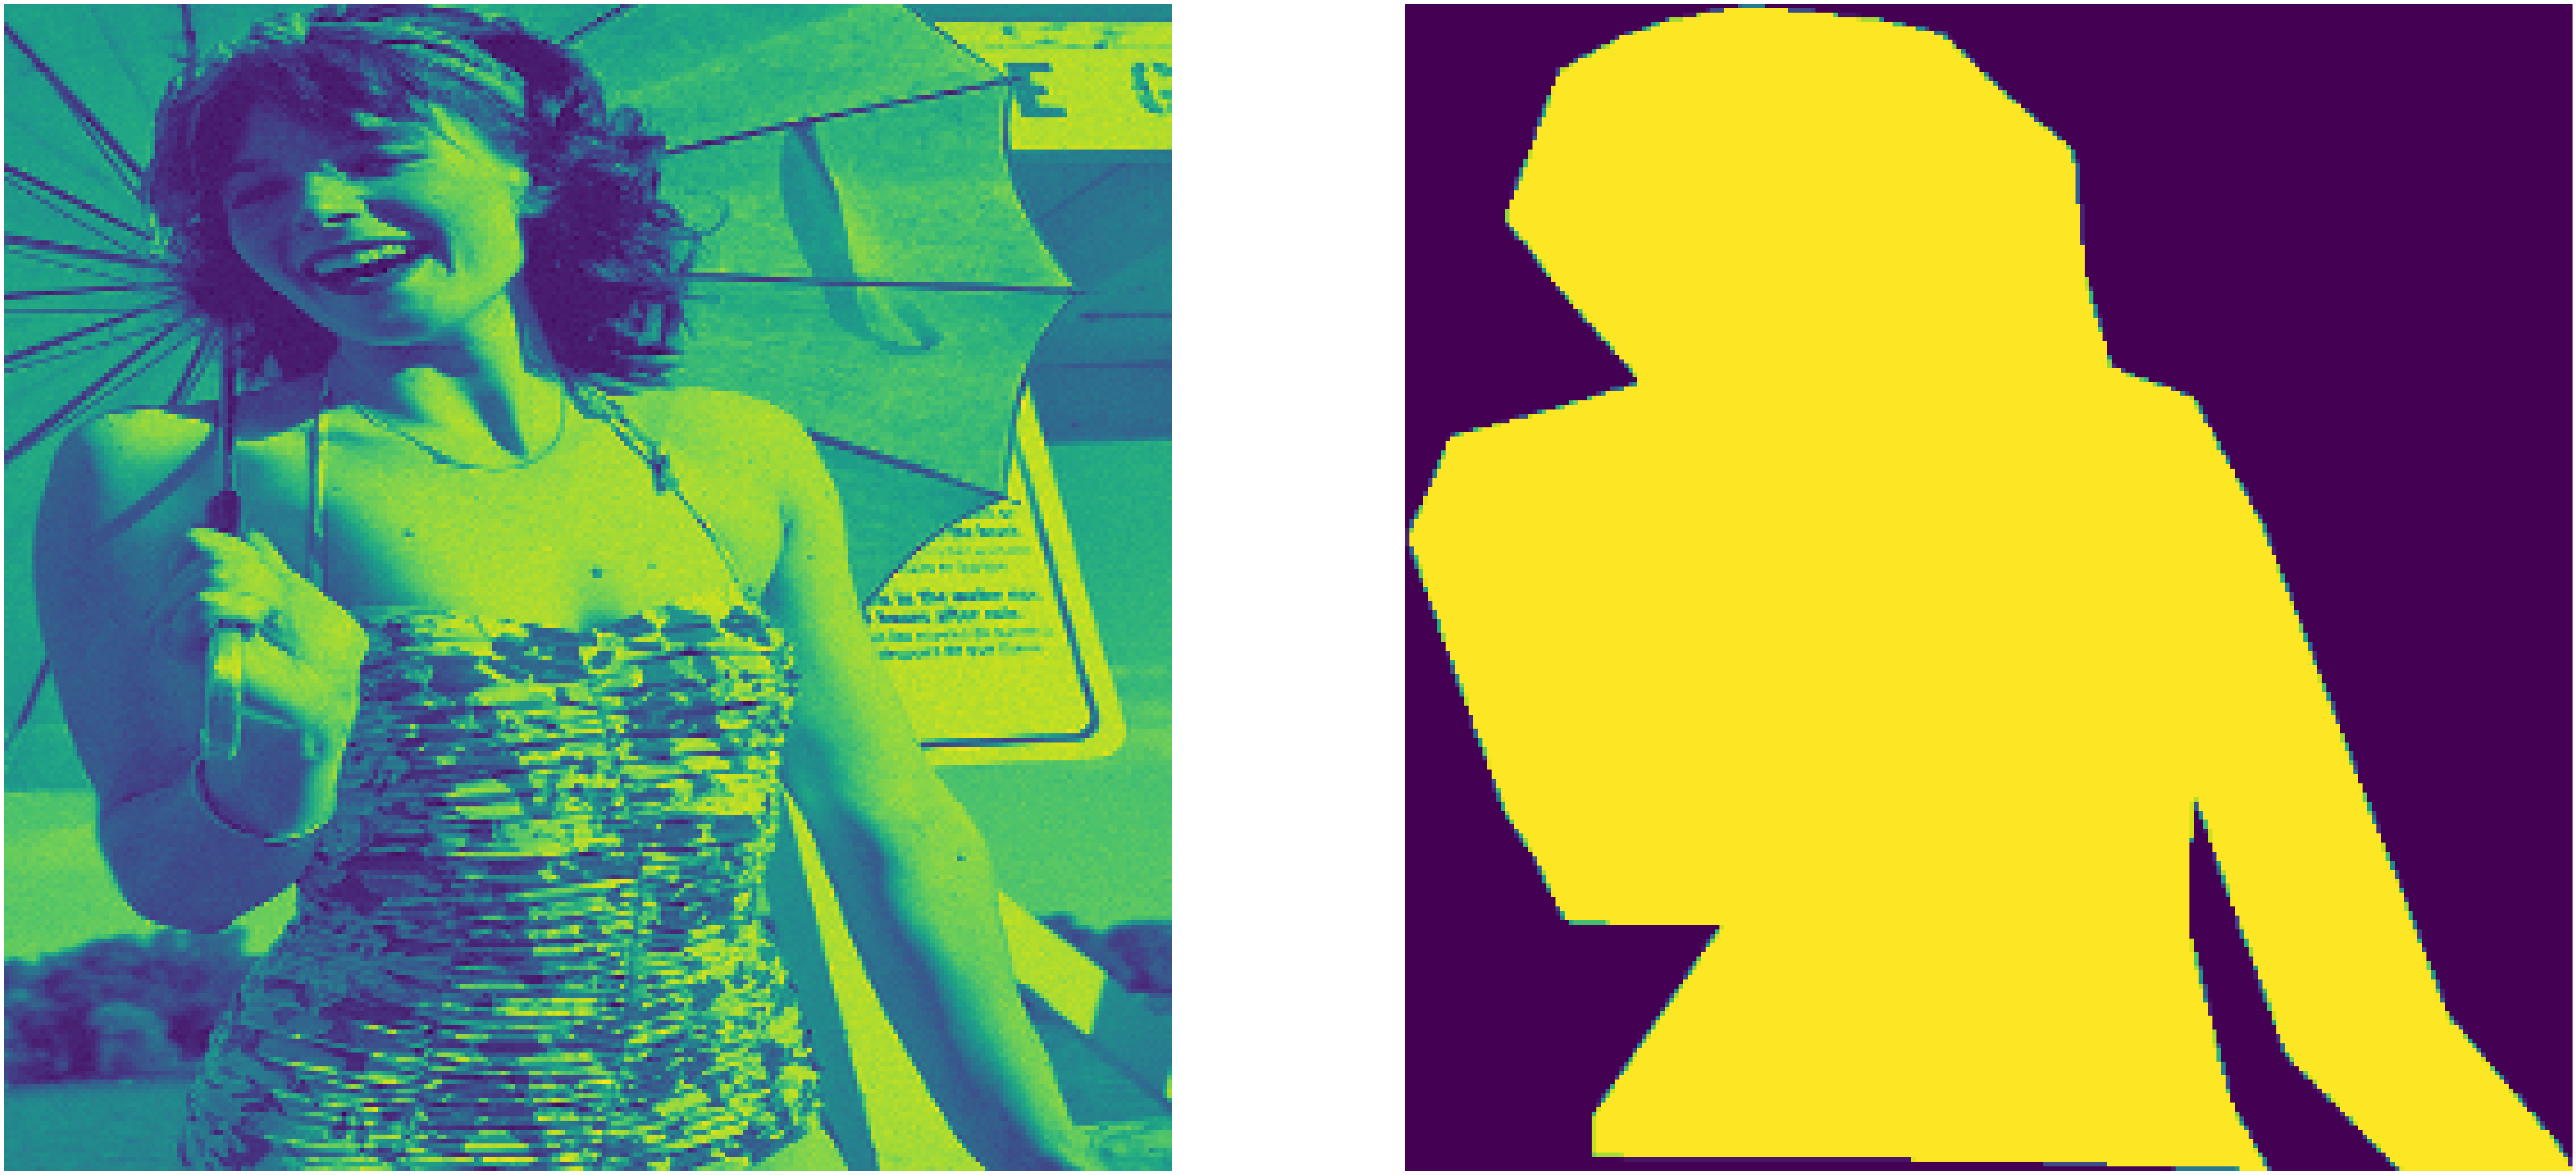

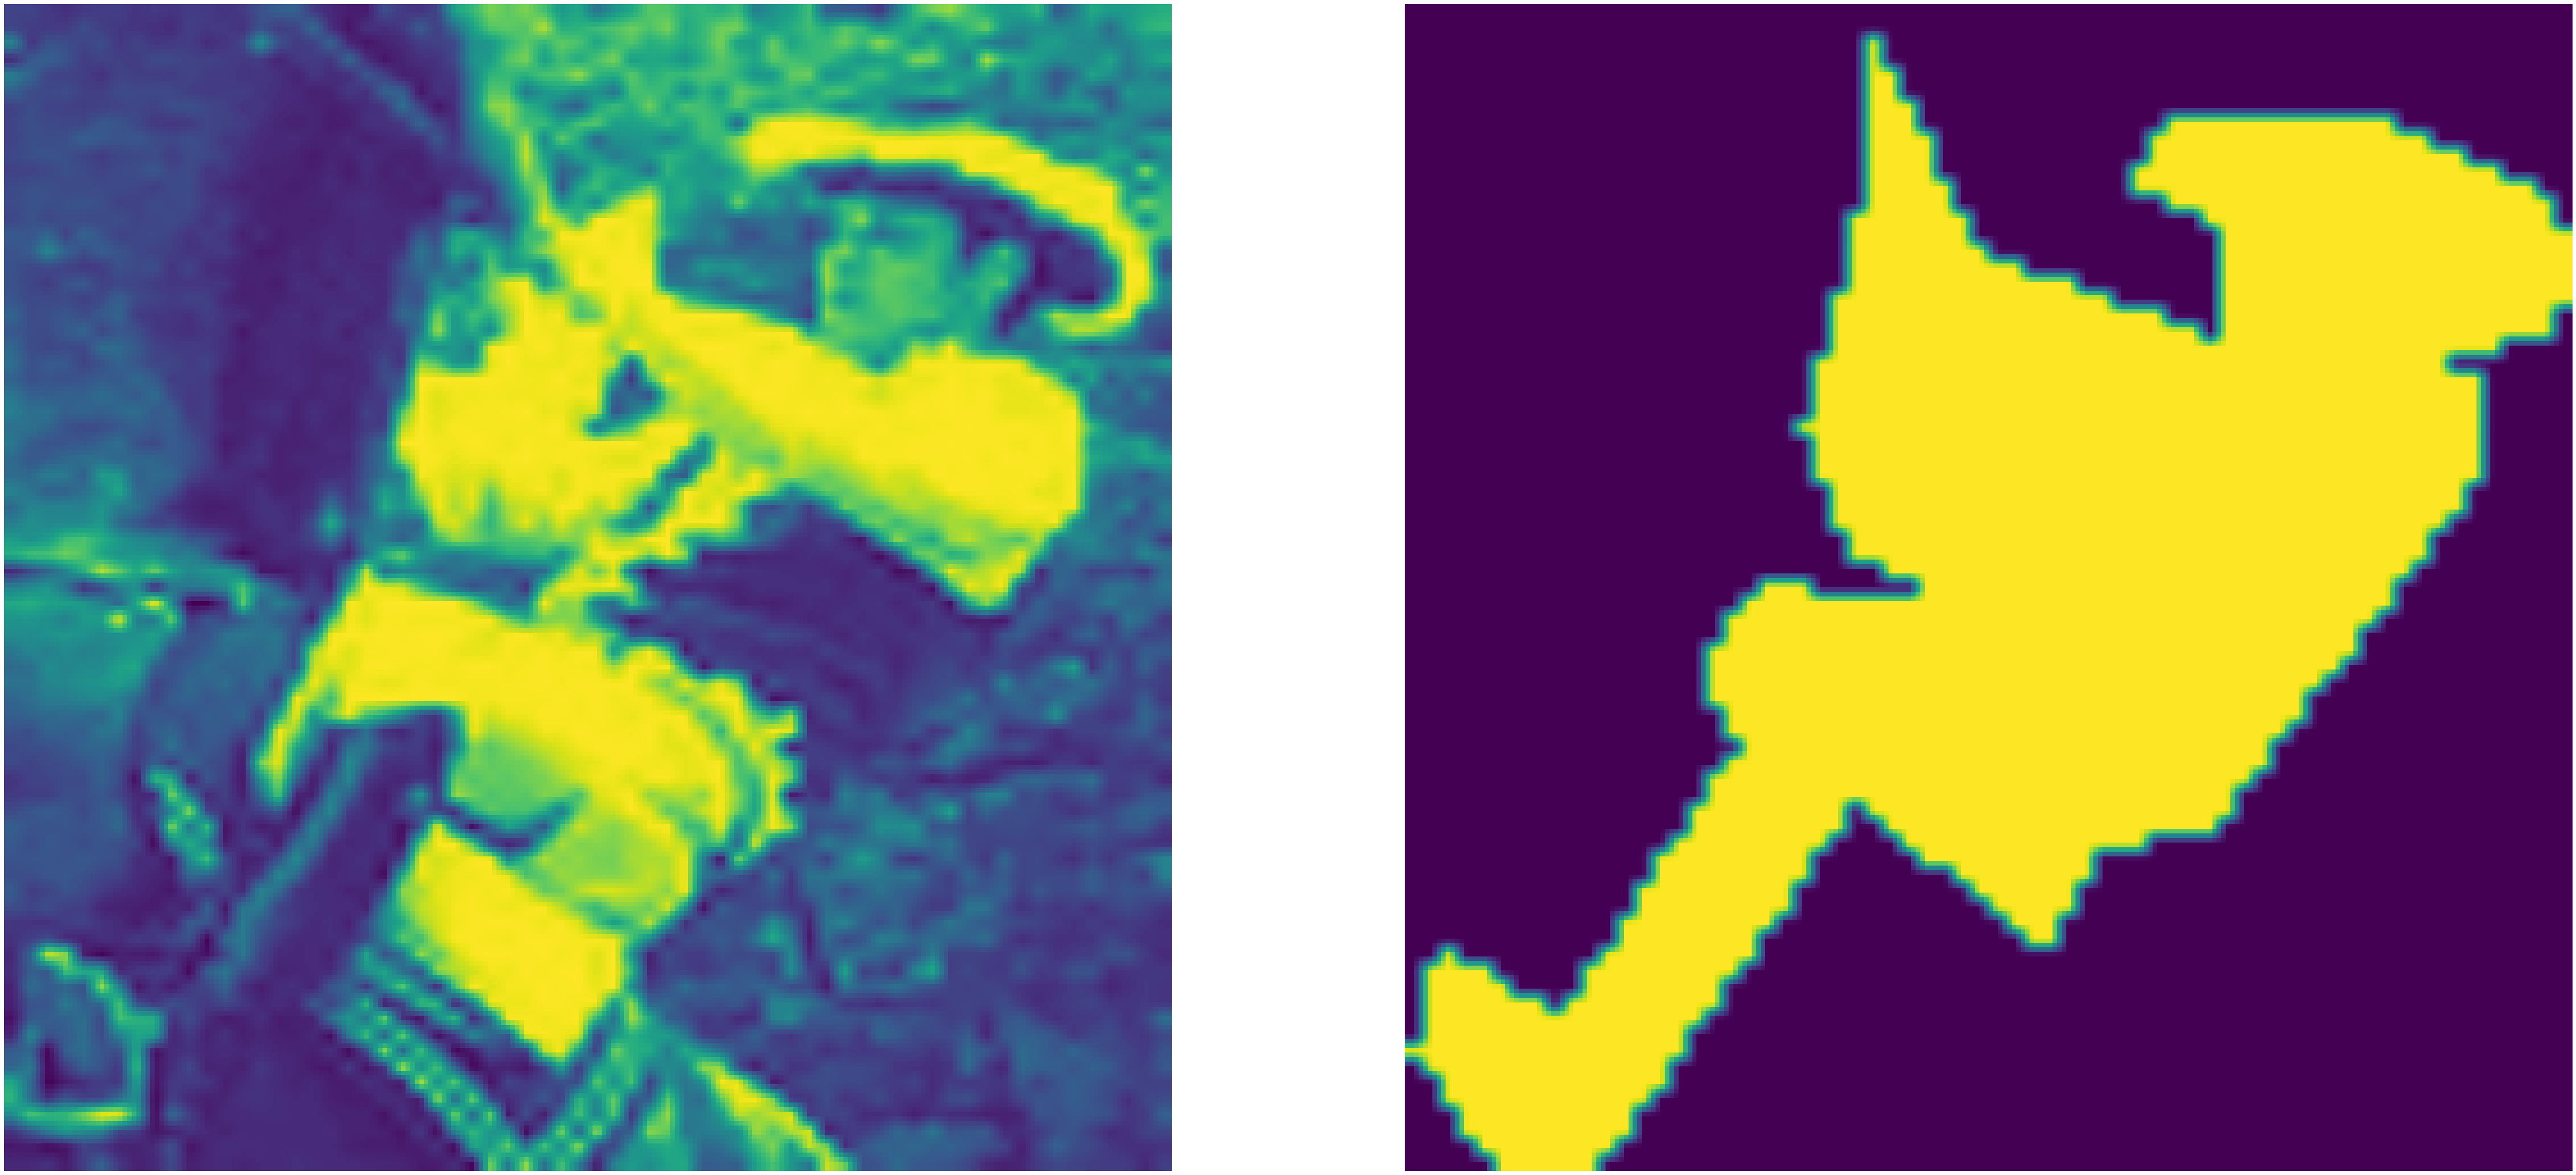

This picture bbox width or height <50
This picture bbox width or height <50


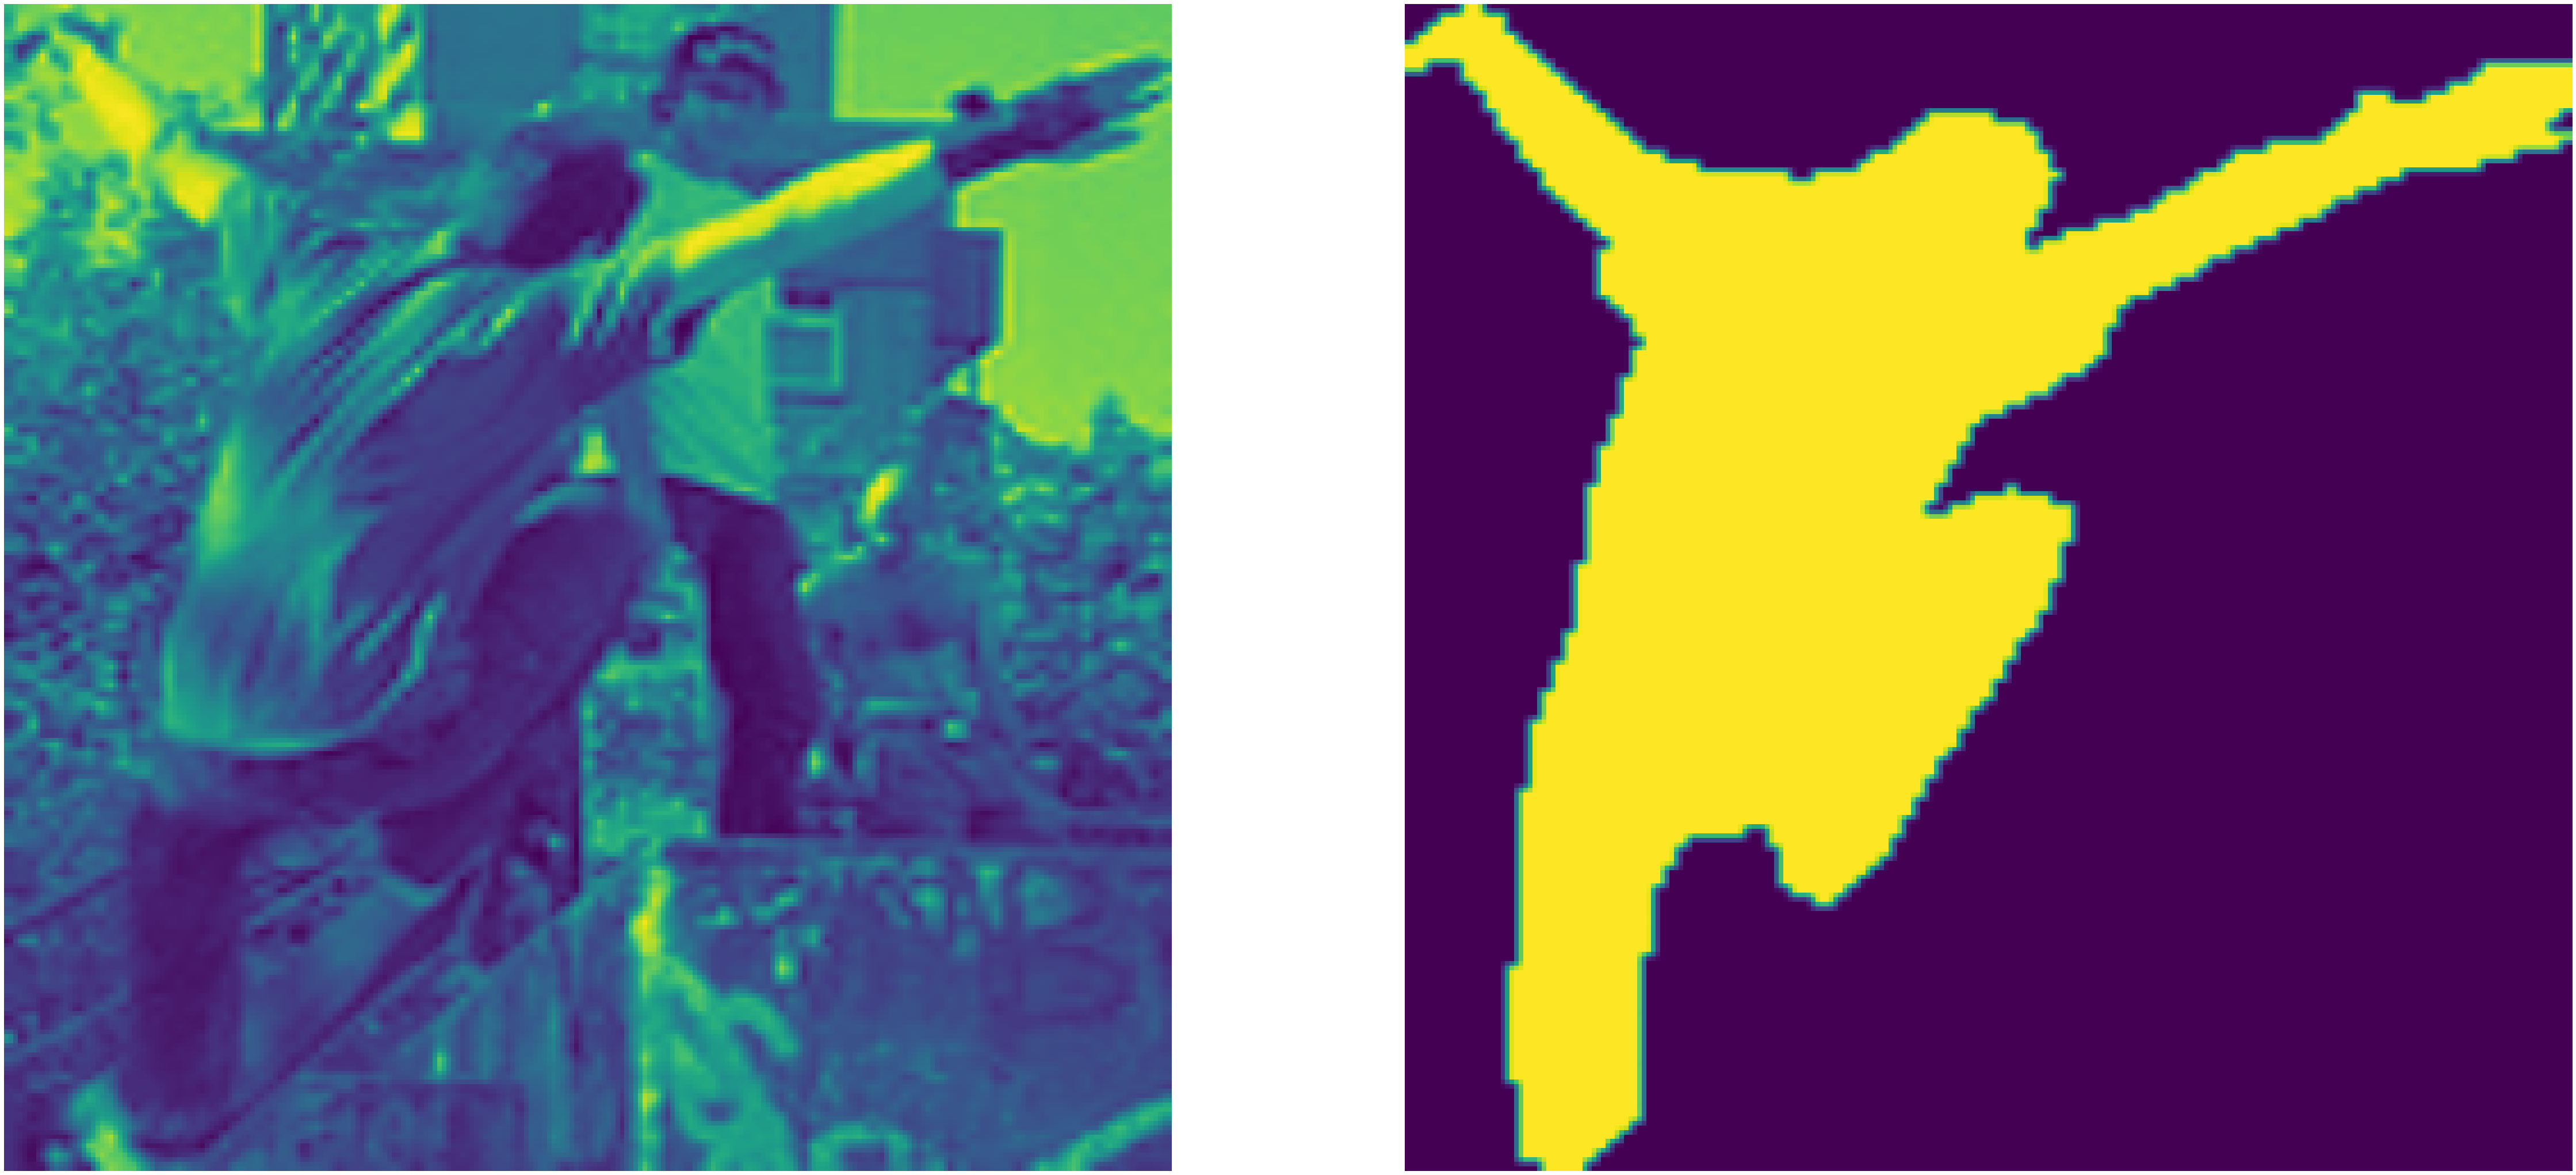

In [36]:
for i in range(0,5):
    try:
        i,m = bask(i,imgPath, isTrain=True)
        vi([i,m])
    except:
        print("This picture bbox width or height <50")

In [39]:
d = bask(0, imgPath)

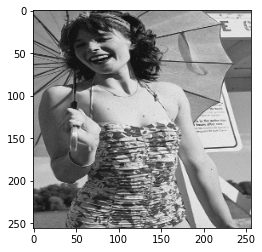

In [40]:
plt.imshow(d[0], cmap="gray")

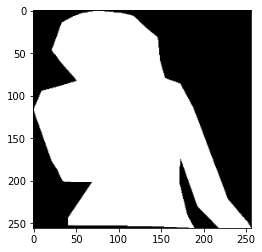

In [41]:
plt.imshow(d[1], cmap="gray")

In [42]:
d[1].shape

(256, 256)

In [43]:
def stored(path, InewPath, MnewPath, ids, isTrain=True):
    name = imgs[ids]
    try:
        i, m = bask(ids, path, isTrain)
        if isTrain:
            cv2.imwrite(MnewPath+"\\train_"+name, m)
            cv2.imwrite(InewPath+"\\train_"+name, i)
        else:    
            cv2.imwrite(MnewPath+"\\val_"+name, m)
            cv2.imwrite(InewPath+"\\val_"+name, i)  
    except:
        pass

In [142]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\train\data"+"\\"
imgs = list(os.listdir(imgPath))
stored(imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", 0, isTrain=True)

In [145]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\raw\val2017"+"\\"
imgs = list(os.listdir(imgPath))
stored(imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", 150, isTrain=False)

In [45]:
def save(imgs, path, InewPath, MnewPath, isTrain=True):
    tar = imgs
    Max = 30
    for n in range(0,len(tar),Max):
        with concurrent.futures.ThreadPoolExecutor(max_workers=Max) as executor:
            for i in range(n, n+len(tar[n:n+Max])):
                executor.submit(stored, path, InewPath, MnewPath, i, isTrain) 

In [46]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\train\data"+"\\"
imgs = list(os.listdir(imgPath))
save(imgs, imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", isTrain=True)

In [174]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\raw\val2017"+"\\"
imgs = list(os.listdir(imgPath))
save(imgs, imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", isTrain=False)